<p style="align: center;"><img align=center src="https://s8.hostingkartinok.com/uploads/images/2018/08/308b49fcfbc619d629fe4604bceb67ac.jpg" width=500 height=450/></p>

<h3 style="text-align: center;"><b>Курс "Глубокое обучение". Первый семестр</b></h3>

# Домашнее задание. Сегментация изображений

Выполнил Булдаков Никита

Telegram: **@BuldakovN**

---


1.Для начала мы скачаем датасет: [ADDI project](https://www.fc.up.pt/addi/ph2%20database.html).

<table><tr><td>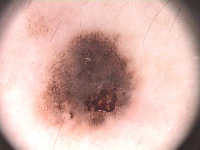</td><td>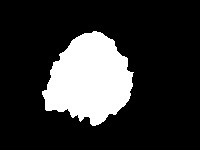</td></tr></table>

2. Разархивируем .rar файл.
3. Обратите внимание, что папка  `PH2 Dataset images` должна лежать там же где и ipynb notebook.

Это фотографии двух типов **поражений кожи:** меланома и родинки.
В данном задании мы не будем заниматься их классификацией, а будем сегментировать их.

In [1]:
import pickle

images = []
lesions = []
from skimage.io import imread
import os
from pathlib import Path
root = '../input/ph2dataset/PH2Dataset/'

for d in Path(root+'PH2_Dataset').iterdir():
    for imd in Path(d).iterdir():
        if str(imd).endswith('_Dermoscopic_Image'):
            images.append(imread(next(imd.iterdir())))
        if str(imd).endswith('_lesion'):
            lesions.append(imread(next(imd.iterdir())))

Изображения имеют разные размеры. Давайте изменим их размер на $256\times256 $ пикселей. [`skimage.transform.resize()`](https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize) можно использовать для изменения размера изображений. 
Эта функция также автоматически нормализует изображения в диапазоне $[0,1]$.


In [2]:
from skimage.transform import resize
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [3]:
import numpy as np
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')
print(len(lesions))

Loaded 200 images
200


Чтобы убедиться, что все корректно, мы нарисуем несколько изображений

In [4]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show();

Разделим наши 200 картинок на 100/50/50
 для валидации и теста

In [5]:
import torch

seed = 19841983
torch.manual_seed(seed)
np.random.seed(seed)

ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])

print(len(tr), len(val), len(ts))

100 50 50


#### PyTorch DataLoader

In [6]:
from torch.utils.data import DataLoader
batch_size = 5
batch_size_test = 25
data_tr = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])), batch_size=batch_size, shuffle=True)
data_vl = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])), batch_size=batch_size_test, shuffle=True)
data_ts = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])), batch_size=batch_size_test, shuffle=True)

In [7]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Реализация различных архитектур:
Ваше задание будет состоять в том, чтобы написать несколько нейросетевых архитектур для решения задачи семантической сегментации. Сравнить их по качеству на тесте и испробовать различные лосс функции для них.

-----------------------------------------------------------------------------------------

# SegNet [2 балла]

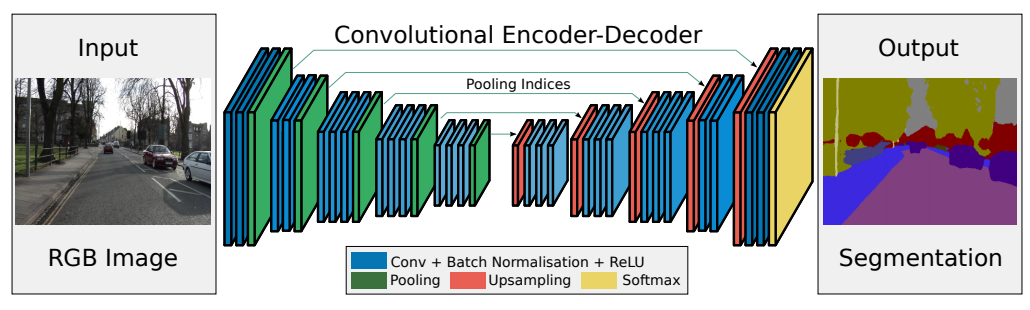

* Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). [SegNet: A deep convolutional
encoder-decoder architecture for image segmentation](https://arxiv.org/pdf/1511.00561.pdf)

Внимательно посмотрите из чего состоит модель и для чего выбраны те или иные блоки.

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time

from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)

import gc

from tqdm import tqdm

Согласно статье, кодирующая часть SegNet представляет собой первые 13 сверточных слоев VGG16. Посмотрим на архитектуру VGG16

In [9]:
from torchvision import datasets, models, transforms

models.vgg16_bn()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [10]:
class conv_batchnorm_relu(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding, relu=True):
        super().__init__()
        self.module = nn.Sequential(
            nn.Conv2d(in_channels, 
                      out_channels, 
                      kernel_size=kernel_size, 
                      padding=padding, 
                      stride=stride),
            nn.BatchNorm2d(out_channels))
        if relu:
            self.module.add_module('relu', nn.ReLU(inplace=True))
                                   
    def forward(self, inputs):
        return self.module(inputs)
    


class SegNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0 = nn.Sequential(
            conv_batchnorm_relu(3, 64, 3, 1, 1),
            conv_batchnorm_relu(64, 64, 3, 1, 1)            
        )
        self.pool0 = nn.MaxPool2d(2, 2, return_indices=True)  # 256 -> 128

        self.enc_conv1 = nn.Sequential(
            conv_batchnorm_relu(64, 128, 3, 1, 1),
            conv_batchnorm_relu(128, 128, 3, 1, 1),       
        )
        self.pool1 = nn.MaxPool2d(2, 2, return_indices=True) # 128 -> 64

        self.enc_conv2 = nn.Sequential(
            conv_batchnorm_relu(128, 256, 3, 1, 1),
            conv_batchnorm_relu(256, 256, 3, 1, 1),
            conv_batchnorm_relu(256, 256, 3, 1, 1)            
        )
        self.pool2 = nn.MaxPool2d(2, 2, return_indices=True) # 64 -> 32

        self.enc_conv3 = nn.Sequential(
            conv_batchnorm_relu(256, 512, 3, 1, 1),
            conv_batchnorm_relu(512, 512, 3, 1, 1),
            conv_batchnorm_relu(512, 512, 3, 1, 1)            
        )
        self.pool3 = nn.MaxPool2d(2, 2, return_indices=True) # 32 -> 16

        # bottleneck
        self.bottle_neck = nn.Sequential(
            conv_batchnorm_relu(512, 1024, 1, 1, 0),
            conv_batchnorm_relu(1024, 512, 1, 1, 0)   
        )

        # decoder (upsampling)

        self.upsample3 = nn.MaxUnpool2d(2, 2) # 16 -> 32
        self.dec_conv3 = nn.Sequential(
            conv_batchnorm_relu(512, 256, 3, 1, 1),
            conv_batchnorm_relu(256, 256, 3, 1, 1),
            conv_batchnorm_relu(256, 256, 3, 1, 1),
        )

        self.upsample2 = nn.MaxUnpool2d(2, 2) # 32 -> 64
        self.dec_conv2 = nn.Sequential(
            conv_batchnorm_relu(256, 128, 3, 1, 1),
            conv_batchnorm_relu(128, 128, 3, 1, 1),
            conv_batchnorm_relu(128, 128, 3, 1, 1),
        )

        self.upsample1 = nn.MaxUnpool2d(2, 2) # 64 -> 128
        self.dec_conv1 = nn.Sequential(
            conv_batchnorm_relu(128, 64, 3, 1, 1),
            conv_batchnorm_relu(64, 64, 3, 1, 1),
        )

        self.upsample0 = nn.MaxUnpool2d(2, 2) # 128 -> 256
        self.dec_conv0 = nn.Sequential(
            conv_batchnorm_relu(64, 1, 3, 1, 1),
            conv_batchnorm_relu(1, 1, 3, 1, 1),
            conv_batchnorm_relu(1, 1, 3, 1, 1, relu=False) # последний слой без функции активации
        )

    def forward(self, x):
        # encoder
        e0, ind0 = self.pool0(self.enc_conv0(x))
        e1, ind1 = self.pool1(self.enc_conv1(e0))
        e2, ind2 = self.pool2(self.enc_conv2(e1))
        e3, ind3 = self.pool3(self.enc_conv3(e2))        

        # bottleneck        
        bottle_neck = self.bottle_neck(e3)

        # decoder
        d3 = self.dec_conv3(self.upsample3(bottle_neck, ind3))
        d2 = self.dec_conv2(self.upsample2(d3, ind2))
        d1 = self.dec_conv1(self.upsample1(d2, ind1))
        d0 = self.dec_conv0(self.upsample0(d1, ind0))

        # no activation
        return d0

## Метрика

В данном разделе предлагается использовать следующую метрику для оценки качества:

$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$

Пересечение (A ∩ B) состоит из пикселей, найденных как в маске предсказания, так и в основной маске истины, тогда как объединение (A ∪ B) просто состоит из всех пикселей, найденных либо в маске предсказания, либо в целевой маске.


In [11]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape
    outputs = outputs.squeeze(1).byte()  # BATCH x 1 x H x W => BATCH x H x W
    labels = labels.squeeze(1).byte()
    
    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zzero if both are 0
    
    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0
    
    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds
    
    return thresholded  # 

## Функция потерь [1 балл]

Теперь не менее важным, чем построение архитектуры, является определение **оптимизатора** и **функции потерь.**

Функция потерь - это то, что мы пытаемся минимизировать. Многие из них могут быть использованы для задачи бинарной семантической сегментации. 

Популярным методом для бинарной сегментации является *бинарная кросс-энтропия*, которая задается следующим образом:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

где $y$ это  таргет желаемого результата и $\hat y$ является выходом модели. $\sigma$ - это [*логистическая* функция](https://en.wikipedia.org/wiki/Sigmoid_function), который преобразует действительное число $\mathbb R$ в вероятность $[0,1]$.

Однако эта потеря страдает от проблем численной нестабильности. Самое главное, что $\lim_{x\rightarrow0}\log(x)=\infty$ приводит к неустойчивости в процессе оптимизации. Рекомендуется посмотреть следующее [упрощение](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits) в Тарая функция эквивалентна и не так подвержена численной неустойчивости.

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right).$$

In [12]:
# аргументы поменял местами в соотвтетвии с документацией библиотечных лоссов
def bce_loss(y_pred, y_real, eps=1e-8):
    # добавим очень маленькое значение eps, чтобы torch.exp не ломался
    #loss = y_pred - y_real*y_pred + torch.log(1 + torch.exp(-y_pred+eps))
    loss = torch.clip(y_pred, min=0) - y_pred * y_real + torch.log(1 + torch.exp(-torch.abs(y_pred)))
    return loss.mean()

## Тренировка [1 балл]

Мы определим цикл обучения в функции, чтобы мы могли повторно использовать его.

In [13]:
def train(model, optimizer, loss_fn, score_fn, epochs, data_tr, data_vl, verbose=False):
    losses_train = []
    losses_val = []
    scores_train = []
    scores_val = []

    for epoch in tqdm(range(epochs)):
        tic = time()
        if verbose: print('* Epoch %d/%d' % (epoch+1, epochs))

        avg_loss = 0
        avg_acc = 0
        model.train()  # train mode
        for X_batch, Y_batch in data_tr:
            # data to device
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)            

            # set parameter gradients to zero
            optimizer.zero_grad()

            # forward
            Y_pred = model(X_batch)
            loss = loss_fn(Y_pred, Y_batch) # forward-pass

            loss.backward()  # backward-pass
            optimizer.step()  # update weights

            # calculate loss to show the user
            avg_loss += loss / len(data_tr)
            avg_acc += score_fn(Y_pred>0.5, Y_batch).mean() / len(data_tr)

        if verbose: print('train_loss: %f' % avg_loss)
        losses_train.append(avg_loss.cpu().detach())
        scores_train.append(avg_acc.cpu().detach())

        # val loss
        avg_loss = 0
        avg_acc = 0
        model.eval()  # testing mode
        for X_val, Y_val in data_vl:
            X_val = X_val.to(device)
            Y_val = Y_val.to(device)
            with torch.no_grad():
                Y_pred = model(X_val) # detach and put into cpu
                loss = loss_fn(Y_pred, Y_val) # forward-pass
                avg_loss += loss / len(data_vl)
                avg_acc += score_fn(Y_pred>0.5, Y_val).mean() / len(data_vl)

        if verbose: print('val_loss: %f' % avg_loss)
        losses_val.append(avg_loss.cpu().detach())
        scores_val.append(avg_acc.cpu().detach())

        gc.collect()
        torch.cuda.empty_cache()
          
    return (losses_train, losses_val, scores_train, scores_val)

## Инференс [1 балл]

После обучения модели эту функцию можно использовать для прогнозирования сегментации на новых данных:

In [14]:
def score_model(model, metric, data):
    model.eval()  # testing mode
    scores = 0
    for X_batch, Y_label in data:
        X_batch = X_batch.to(device)
        Y_label = Y_label.to(device)
        Y_pred = model(X_batch)
        Y_pred = Y_pred>0.5
        scores += metric(Y_pred, Y_label).mean().item()

    return scores/len(data)

## Основной момент: обучение

Обучите вашу модель. Обратите внимание, что обучать необходимо до сходимости. Если указанного количества эпох (20) не хватило, попробуйте изменять количество эпох до сходимости алгоритма. Сходимость определяйте по изменению функции потерь на валидационной выборке.
 С параметрами оптимизатора можно спокойно играть, пока вы не найдете лучший вариант для себя.


In [15]:
def plot_results(rslts, ttl=''):
    plt.figure(figsize=(15, 9))
    plt.plot(rslts[0], label="train_loss")
    plt.plot(rslts[1], label="val_loss")
    plt.plot(rslts[2], label="train_score")
    plt.plot(rslts[3], label="val_score")

    plt.legend(loc='best')
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.title(ttl)

    plt.show()

In [16]:
segnet = SegNet().to(device)
#segnet_bce = nn.DataParallel(segnet_bce).to(device)
optimizer = torch.optim.Adam(segnet.parameters())
segnet_bce_history = train(segnet, optimizer, bce_loss, iou_pytorch, 100, data_tr, data_vl)

  0%|          | 0/100 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:749: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"
100%|██████████| 100/100 [04:40<00:00,  2.80s/it]


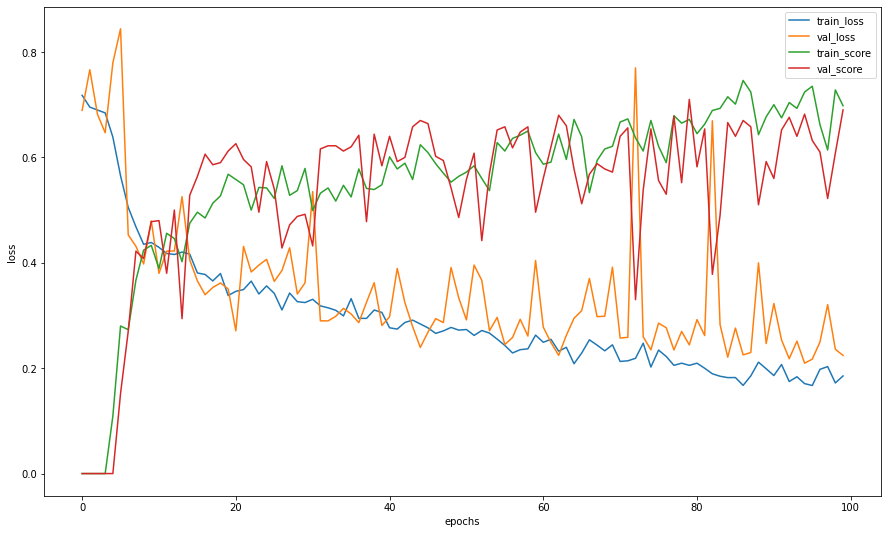

0.7177292108535767

In [17]:
plot_results(segnet_bce_history)
segnet_bce_history[0][0].item()

In [18]:
# Проверим скор обученной модели на валидационной и тестовой выборках
print(score_model(segnet, iou_pytorch, data_vl), score_model(segnet, iou_pytorch, data_ts))

0.6899999976158142 0.6720000505447388


In [19]:
def plot_items(model, loader, cnt):

    model.eval()
    X, Y = next(iter(loader))
    X = X.to(device)
    Y_pred = model(X)

    p = Y_pred.detach().cpu()
    p_post = torch.ones_like(p) * (p > 0.5)
    y = Y
    
    plt.figure(figsize=(15, 10))
    for i in range(cnt):
        plt.subplot(3, cnt, i+1+cnt*0)
        plt.imshow(np.rollaxis(p[i,0].numpy(), 0), cmap='gray')
        plt.title('Output')
        plt.axis('off')
        
        plt.subplot(3, cnt, i+1+cnt*1)
        plt.imshow(np.rollaxis(p_post[i,0].numpy(), 0), cmap='gray')
        plt.title('Post-processing')
        plt.axis('off')

        plt.subplot(3, cnt, i+1+cnt*2)
        plt.imshow(np.rollaxis(y[i,0].numpy(), 0), cmap='gray')
        plt.title('Real')
        plt.axis('off')

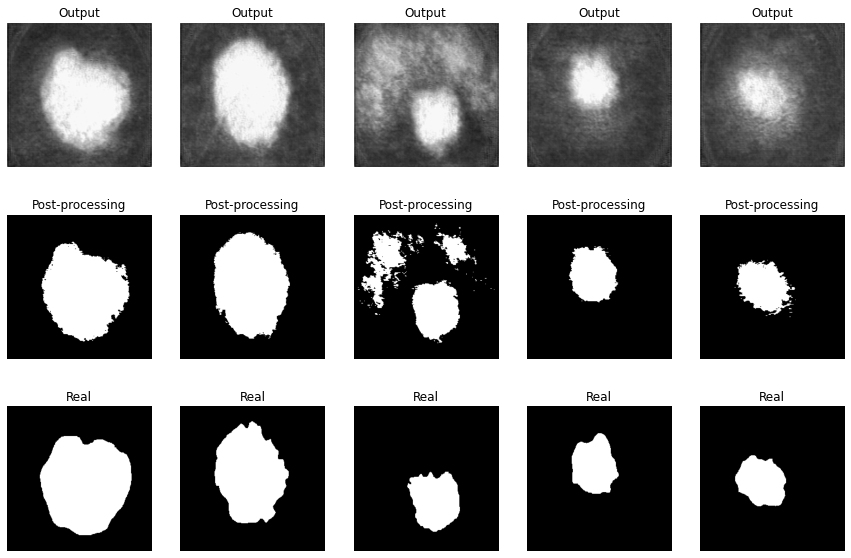

In [20]:
# На тестовой выборке сравним выходы модели c масками из обучающей выборки

plot_items(segnet, data_ts, 5)

Ответьте себе на вопрос: не переобучается ли моя модель?

Судя по нарастающему примерно с 100 эпохи разрыву в скоре, а также по нарастающему с 110 этопи расхождению между функцией потерь для обучающей и для валидационной выборки - да, модель несколько переобучилась. Но она и должна, обучающая выборка слишком мала, её легко запомнить для модели таких размеров.

-----------------------------------------------------------------------------------------

## Дополнительные функции потерь [2 балла] 

 В данном разделе вам потребуется имплементировать две функции потерь:
 DICE и Focal loss. 
 Если у вас что-то не учится, велика вероятность, что вы ошиблись или учите слишком мало, прежде чем бить тревогу попробуйте поперебирать различные варианты, убедитесь, что во всех других сетапах сетть достигает желанного результата. СПОЙЛЕР: учиться она будеет при всех лоссах предложенных в этом задании.


**1. Dice coefficient:** Учитывая две маски $X$ и $Y$, общая метрика для измерения расстояния между этими двумя масками задается следующим образом:

$$D(X,Y)=\frac{2|X\cap Y|}{|X|+|Y|}$$

Эта функция не является дифференцируемой, но это необходимое свойство для градиентного спуска. В данном случае мы можем приблизить его с помощью:

$$\mathcal L_D(X,Y) = 1-\frac{1}{256 \times 256} \times \sum_i\frac{2X_iY_i}{X_i+Y_i}.$$

Не забудьте подумать о численной нестабильности, возникаемой в математической формуле.


In [21]:
def dice_loss(y_pred, y_real, eps=1e-8):
    y_pred = y_pred.sigmoid()   
    s1 = 2*(y_pred*y_real).sum()
    s2 = (y_pred+y_real).sum()
    result = 1 - s1/s2
    return result

Проводим тестирование:

In [22]:
segnet = SegNet().to(device)
#segnet = nn.DataParallel(segnet).to(device)
optimizer = torch.optim.Adam(segnet.parameters())
segnet_dice_history = train(segnet, optimizer, dice_loss, iou_pytorch, 100, data_tr, data_vl)

100%|██████████| 100/100 [04:35<00:00,  2.75s/it]


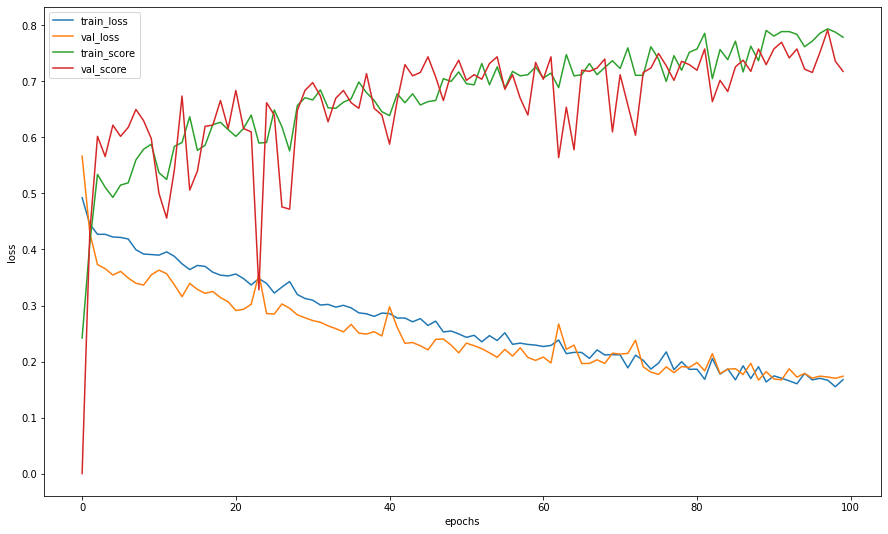

In [23]:
plot_results(segnet_dice_history)

In [24]:
print (score_model(segnet, iou_pytorch, data_vl), score_model(segnet, iou_pytorch, data_ts))

0.7179999649524689 0.6779999732971191


[**2. Focal loss:**](https://arxiv.org/pdf/1708.02002.pdf) 

Окей, мы уже с вами умеем делать BCE loss:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Проблема с этой потерей заключается в том, что она имеет тенденцию приносить пользу классу **большинства** (фоновому) по отношению к классу **меньшинства** ( переднему). Поэтому обычно применяются весовые коэффициенты к каждому классу:

$$\mathcal L_{wBCE}(y, \hat y) = -\sum_i \alpha_i\left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Традиционно вес $\alpha_i$ определяется как обратная частота класса этого пикселя $i$, так что наблюдения миноритарного класса весят больше по отношению к классу большинства.

Еще одним недавним дополнением является взвешенный пиксельный вариант, которая взвешивает каждый пиксель по степени уверенности, которую мы имеем в предсказании этого пикселя.

$$\mathcal L_{focal}(y, \hat y) = -\sum_i \left[\left(1-\sigma(\hat y_i)\right)^\gamma y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Зафиксируем значение $\gamma=2$.

--------------------------------------------------------------------------------


In [25]:
def focal_loss(y_pred, y_real, eps = 1e-6, gamma = 2):
    y = y_pred.sigmoid()
    loss = -((1-y+eps)**gamma*y_real*(y+eps).log()+(1-y_real)*(1-y+eps).log())
    return loss.mean()

In [26]:
segnet = SegNet().to(device)
#segnet = nn.DataParallel(segnet).to(device)
optimizer = torch.optim.Adam(segnet.parameters())
segnet_focal_history = train(segnet, optimizer, focal_loss, iou_pytorch, 100, data_tr, data_vl)

100%|██████████| 100/100 [04:34<00:00,  2.74s/it]


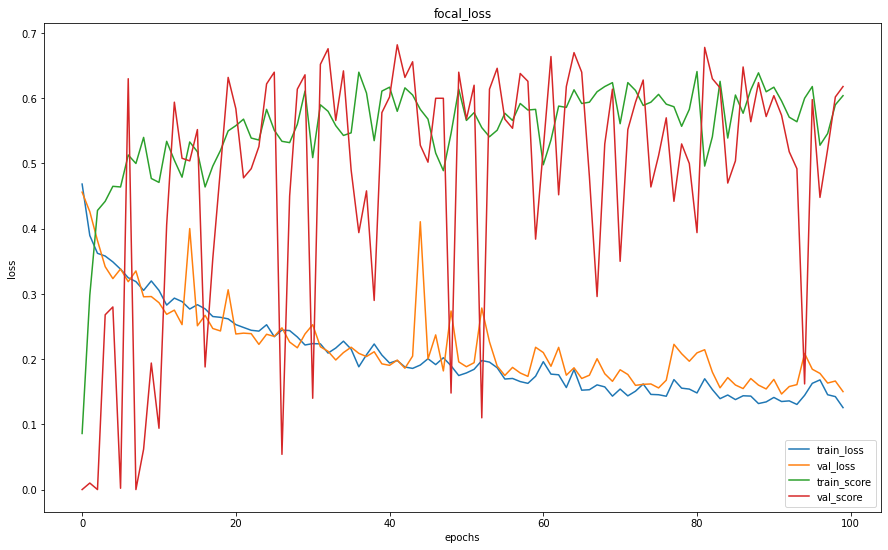

In [27]:
plot_results(segnet_focal_history, 'focal_loss')

In [28]:
print (score_model(segnet, iou_pytorch, data_vl), score_model(segnet, iou_pytorch, data_ts))

0.6180000305175781 0.5979999601840973


----------------------------------------------------------------------------------------------

## [BONUS] Мир сегментационных лоссов [5 баллов]

В данном блоке предлагаем вам написать одну функцию потерь самостоятельно. Для этого необходимо прочитать статью и имплементировать ее. Кроме тако провести численное сравнение с предыдущими функциями.
Какие варианты? 

1) Можно учесть Total Variation
2) Lova
3) BCE но с Soft Targets (что-то типа label-smoothing для многослассовой классификации)
4) Любой другой 

* [Physiological Inspired Deep Neural Networks for Emotion Recognition](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8472816&tag=1)". IEEE Access, 6, 53930-53943.

* [Boundary loss for highly unbalanced segmentation](https://arxiv.org/abs/1812.07032)

* [Tversky loss function for image segmentation using 3D fully convolutional deep networks](https://arxiv.org/abs/1706.05721)

* [Correlation Maximized Structural Similarity Loss for Semantic Segmentation](https://arxiv.org/abs/1910.08711)

* [Topology-Preserving Deep Image Segmentation](https://papers.nips.cc/paper/8803-topology-preserving-deep-image-segmentation)

Так как Тверский лосс очень похож на данные выше, то за него будет проставлено только 3 балла (при условии, если в модели нет ошибок при обучении). Постарайтесь сделать что-то интереснее.

Будем использовать Total Variation в качестве регуляризации для DICE loss. Смысл Total Variation в том, что он дает штраф, если на изображении есть нечеткие границы

In [90]:
def tensor_size(t):
    return t.size()[1]*t.size()[2]*t.size()[3]

def TV_loss(x, TVLoss_weight=1):
    batch_size = x.size()[0]
    h_x = x.size()[2]
    w_x = x.size()[3]
    count_h = tensor_size(x[:,:,1:,:])
    count_w = tensor_size(x[:,:,:,1:])
    h_tv = torch.pow((x[:,:,1:,:]-x[:,:,:h_x-1,:]),2).sum()
    w_tv = torch.pow((x[:,:,:,1:]-x[:,:,:,:w_x-1]),2).sum()
    return TVLoss_weight*(h_tv/count_h+w_tv/count_w)/batch_size

# аргументы поменял местами в соотвтетвии с документацией библиотечных лоссов
def dice_TV_loss(y_pred, y_real, eps=1e-8):
    y_pred = y_pred.sigmoid()   
    s1 = 2*(y_pred*y_real).sum()
    s2 = (y_pred+y_real).sum()
    result = 1 - s1/s2 + TV_loss(y_pred)
    return result

In [91]:
segnet = SegNet().to(device)
#segnet = nn.DataParallel(segnet).to(device)
optimizer = torch.optim.Adam(segnet.parameters())
segnet_dice_TV_history = train(segnet, optimizer, dice_TV_loss, iou_pytorch, 100, data_tr, data_vl)

100%|██████████| 100/100 [04:34<00:00,  2.75s/it]


In [92]:
print (score_model(segnet, iou_pytorch, data_vl), score_model(segnet, iou_pytorch, data_ts))

0.6979999840259552 0.679999977350235


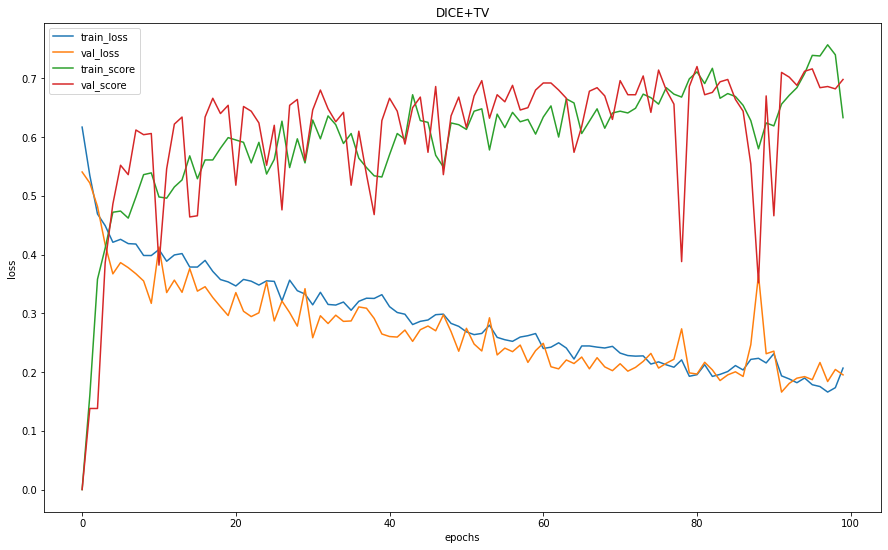

In [95]:
plot_results(segnet_dice_TV_history, 'DICE+TV')

In [97]:
plot_items(segnet, data_ts, 5)

-----------------------------------------------------------------------------------------

# U-Net [2 балла]

[**U-Net**](https://arxiv.org/abs/1505.04597) это архитектура нейронной сети, которая получает изображение и выводит его. Первоначально он был задуман для семантической сегментации (как мы ее будем использовать), но он настолько успешен, что с тех пор используется в других контекстах. Учитывая медицинское изображение, он выводит изображение в оттенках серого, представляющее вероятность того, что каждый пиксель является интересующей областью.

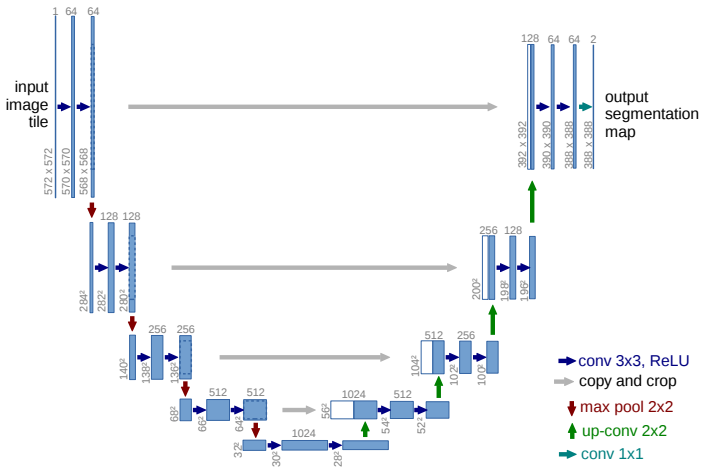

У нас в архитектуре все так же существует енкодер и декодер, как в **SegNet**, но отличительной особеностью данной модели являются skip-conenctions. Элементы соединяющие части декодера и енкодера. То есть для того чтобы передать на вход декодера тензор, мы конкатенируем симметричный выход с энкодера и выход предыдущего слоя декодера.

* Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. "[U-Net: Convolutional networks for biomedical image segmentation.](https://arxiv.org/pdf/1505.04597.pdf)" International Conference on Medical image computing and computer-assisted intervention. Springer, Cham, 2015.

In [33]:
class conv_batchnorm_relu(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding, relu=True):
        super().__init__()
        self.module = nn.Sequential(
            nn.Conv2d(in_channels, 
                      out_channels, 
                      kernel_size=kernel_size, 
                      padding=padding, 
                      stride=stride),
            nn.BatchNorm2d(out_channels))
        if relu:
            self.module.add_module('relu', nn.ReLU(inplace=True))
    
    def forward(self, inputs):
        return self.module(inputs)

class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0 = nn.Sequential(
            conv_batchnorm_relu(3, 64, 3, 1, 1),
            conv_batchnorm_relu(64, 64, 3, 1, 1)            
        )
        self.pool0 = nn.MaxPool2d(2, 2, return_indices=True)  # 256 -> 128

        self.enc_conv1 = nn.Sequential(
            conv_batchnorm_relu(64, 128, 3, 1, 1),
            conv_batchnorm_relu(128, 128, 3, 1, 1),       
        )
        self.pool1 = nn.MaxPool2d(2, 2, return_indices=True) # 128 -> 64

        self.enc_conv2 = nn.Sequential(
            conv_batchnorm_relu(128, 256, 3, 1, 1),
            conv_batchnorm_relu(256, 256, 3, 1, 1),
            conv_batchnorm_relu(256, 256, 3, 1, 1)            
        )
        self.pool2 = nn.MaxPool2d(2, 2, return_indices=True) # 64 -> 32

        self.enc_conv3 = nn.Sequential(
            conv_batchnorm_relu(256, 512, 3, 1, 1),
            conv_batchnorm_relu(512, 512, 3, 1, 1),
            conv_batchnorm_relu(512, 512, 3, 1, 1)            
        )
        self.pool3 = nn.MaxPool2d(2, 2, return_indices=True) # 32 -> 16

        self.bottle_neck = nn.Sequential(
            conv_batchnorm_relu(512, 1024, 1, 1, 0),
            conv_batchnorm_relu(1024, 512, 1, 1, 0)   
        )

        self.upsample3 = nn.MaxUnpool2d(2, 2) # 16 -> 32
        self.dec_conv3 = nn.Sequential(
            conv_batchnorm_relu(512*2, 256, 3, 1, 1),
            conv_batchnorm_relu(256, 256, 3, 1, 1),
            conv_batchnorm_relu(256, 256, 3, 1, 1),
        )

        self.upsample2 = nn.MaxUnpool2d(2, 2) # 32 -> 64
        self.dec_conv2 = nn.Sequential(
            conv_batchnorm_relu(256*2, 128, 3, 1, 1),
            conv_batchnorm_relu(128, 128, 3, 1, 1),
            conv_batchnorm_relu(128, 128, 3, 1, 1),
        )

        self.upsample1 = nn.MaxUnpool2d(2, 2) # 64 -> 128
        self.dec_conv1 = nn.Sequential(
            conv_batchnorm_relu(128*2, 64, 3, 1, 1),
            conv_batchnorm_relu(64, 64, 3, 1, 1),
        )

        self.upsample0 = nn.MaxUnpool2d(2, 2) # 128 -> 256
        self.dec_conv0 = nn.Sequential(
            conv_batchnorm_relu(64*2, 1, 3, 1, 1),
            conv_batchnorm_relu(1, 1, 3, 1, 1),
            conv_batchnorm_relu(1, 1, 3, 1, 1, relu=True)
        )

    def forward(self, x):
        # encoder
        pre_e0 = self.enc_conv0(x)
        e0, ind0 = self.pool0(pre_e0)
        pre_e1 = self.enc_conv1(e0)
        e1, ind1 = self.pool1(pre_e1)
        pre_e2 = self.enc_conv2(e1)
        e2, ind2 = self.pool2(pre_e2)
        pre_e3 = self.enc_conv3(e2)
        e3, ind3 = self.pool3(pre_e3)        

        # bottleneck        
        bottle_neck = self.bottle_neck(e3)

        # decoder
        d3 = self.dec_conv3(torch.cat([self.upsample3(bottle_neck, ind3), pre_e3], 1))
        d2 = self.dec_conv2(torch.cat([self.upsample2(d3, ind2), pre_e2], 1))
        d1 = self.dec_conv1(torch.cat([self.upsample1(d2, ind1), pre_e1], 1))
        d0 = self.dec_conv0(torch.cat([self.upsample0(d1, ind0), pre_e0], 1))

        # no activation
        return d0

In [105]:
unet = UNet().to(device)
#unet = nn.DataParallel(unet).to(device)
optimizer = torch.optim.Adam(unet.parameters())
unet_bce_history = train(unet, optimizer, bce_loss, iou_pytorch, 100, data_tr, data_vl)

unet = UNet().to(device)
#unet = nn.DataParallel(unet).to(device)
optimizer = torch.optim.Adam(unet.parameters())
unet_dice_history = train(unet, optimizer, dice_loss, iou_pytorch, 100, data_tr, data_vl)

unet = UNet().to(device)
#unet = nn.DataParallel(unet).to(device)
optimizer = torch.optim.Adam(unet.parameters())
unet_focal_history = train(unet, optimizer, focal_loss, iou_pytorch, 100, data_tr, data_vl)

unet = UNet().to(device)
#unet = nn.DataParallel(unet).to(device)
optimizer = torch.optim.Adam(unet.parameters())
unet_dice_TV_history = train(unet, optimizer, dice_TV_loss, iou_pytorch, 100, data_tr, data_vl)

100%|██████████| 100/100 [05:12<00:00,  3.12s/it]


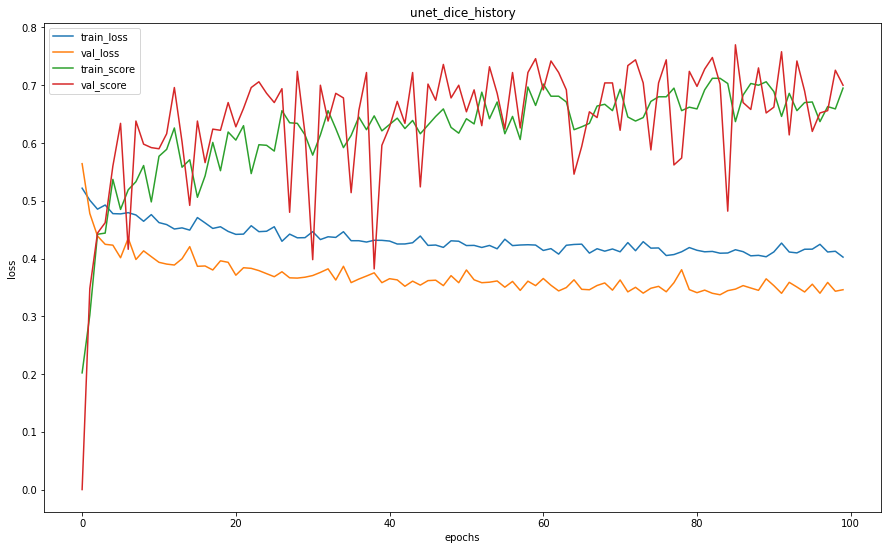

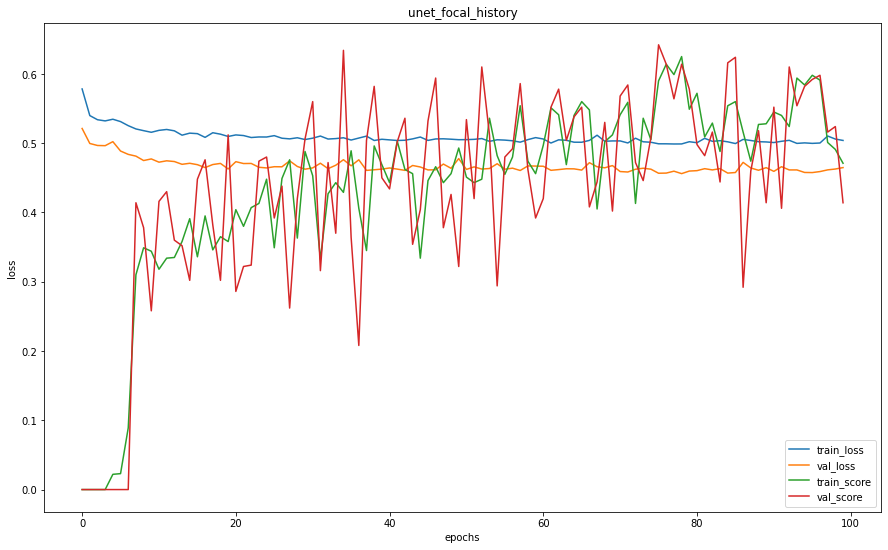

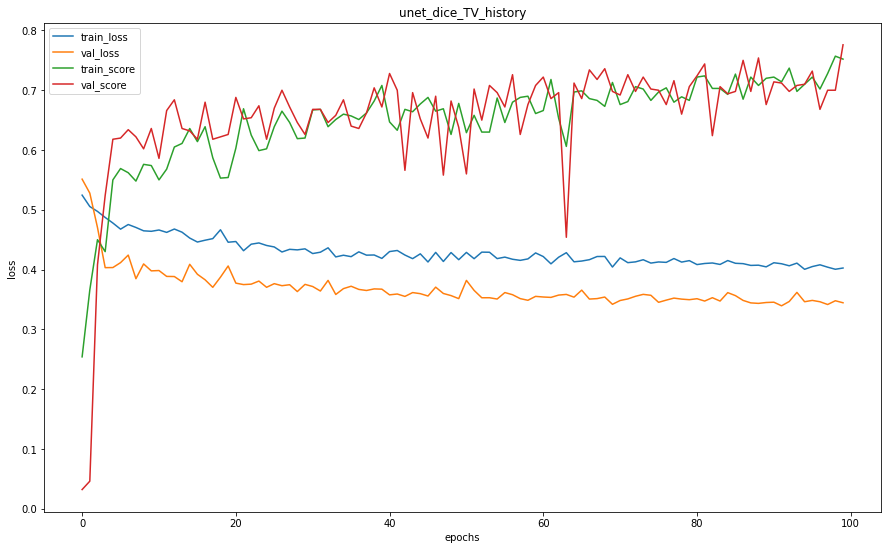

In [106]:
plot_results(unet_bce_history, 'unet_bce_history')
plot_results(unet_dice_history, 'unet_dice_history')
plot_results(unet_focal_history, 'unet_focal_history')
plot_results(unet_dice_TV_history, 'unet_dice_TV_history')

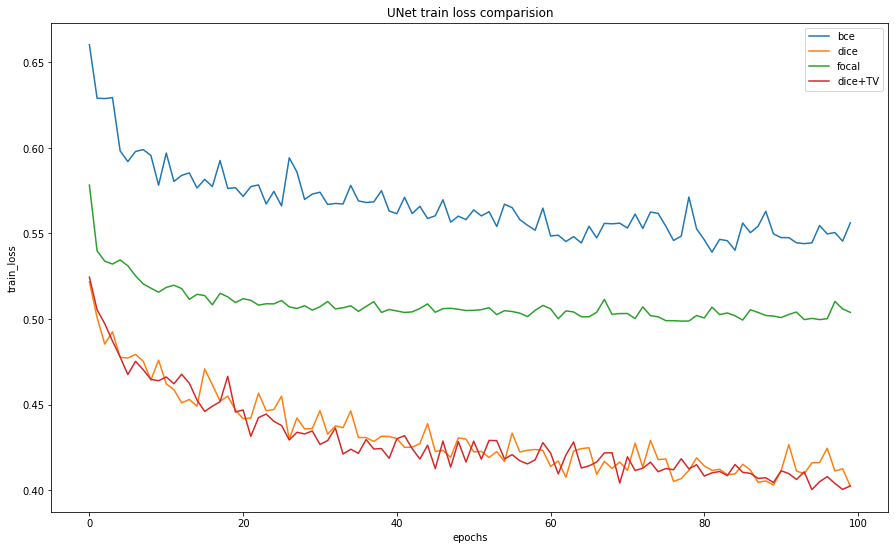

In [107]:
ind=0
plt.figure(figsize=(15, 9))
plt.plot(unet_bce_history[ind], label="bce")
plt.plot(unet_dice_history[ind], label="dice")
plt.plot(unet_focal_history[ind], label="focal")
plt.plot(unet_dice_TV_history[ind], label="dice+TV")

plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("train_loss")
plt.title("UNet train loss comparision")
plt.show()

focal_loss сходится быстрее и стабильнее всех.

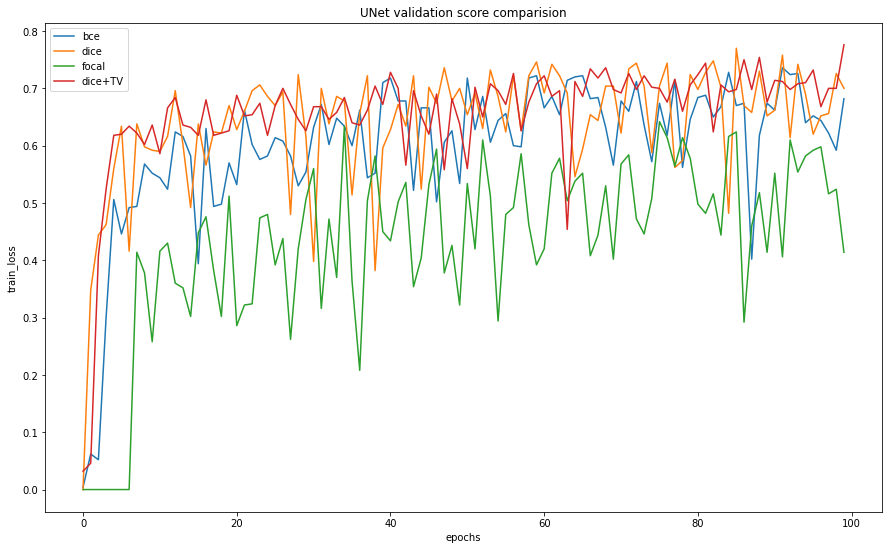

In [108]:
ind=3
plt.figure(figsize=(15, 9))
plt.plot(unet_bce_history[ind], label="bce")
plt.plot(unet_dice_history[ind], label="dice")
plt.plot(unet_focal_history[ind], label="focal")
plt.plot(unet_dice_TV_history[ind], label="dice+TV")

plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("train_loss")
plt.title("UNet validation score comparision")
plt.show()

Из графиков валидационных оценок сложно сделать вывод, какой вариант даёт более качественный прогноз. Слишком большие выбросы. Возможно, слишком мало данных и сеть перееобучается. На Симпсонах всё было более гладко и предсказуемо. Посмотрим на сглаженные значения.

In [109]:
from statistics import mean 

ind=3
plt.plot(unet_bce_history[ind], label="bce")
plt.plot(unet_dice_history[ind], label="dice")
plt.plot(unet_focal_history[ind], label="focal")
plt.plot(unet_dice_TV_history[ind], label="dice+TV")

plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("train_loss")
plt.title("UNet smoothed validation score comparision")
plt.show()

Новая модель путем изменения типа пулинга:

 **Max-Pooling** for the downsampling and **nearest-neighbor Upsampling** for the upsampling.

Down-sampling:

        conv = nn.Conv2d(3, 64, 3, padding=1)
        pool = nn.MaxPool2d(3, 2, padding=1)

Up-Sampling

        upsample = nn.Upsample(32)
        conv = nn.Conv2d(64, 64, 3, padding=1)

Замените max-pooling на convolutions с stride=2 и upsampling на transpose-convolutions с stride=2.


In [110]:
class conv_batchnorm_relu(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding, relu=True):
        super().__init__()
        self.module = nn.Sequential(
            nn.Conv2d(in_channels, 
                      out_channels, 
                      kernel_size=kernel_size, 
                      padding=padding, 
                      stride=stride),
            nn.BatchNorm2d(out_channels))
        if relu:
            self.module.add_module('relu', nn.ReLU(inplace=True))
    
    def forward(self, inputs):
        return self.module(inputs)

class UNet2(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0 = nn.Sequential(
            conv_batchnorm_relu(3, 64, 3, 1, 1),
            conv_batchnorm_relu(64, 64, 3, 1, 1)            
        )
        self.pool0 = nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1) # 256 -> 128

        self.enc_conv1 = nn.Sequential(
            conv_batchnorm_relu(64, 128, 3, 1, 1),
            conv_batchnorm_relu(128, 128, 3, 1, 1),       
        )
        self.pool1 = nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=1) # 128 -> 64

        self.enc_conv2 = nn.Sequential(
            conv_batchnorm_relu(128, 256, 3, 1, 1),
            conv_batchnorm_relu(256, 256, 3, 1, 1),
            conv_batchnorm_relu(256, 256, 3, 1, 1)            
        )
        self.pool2 = nn.Conv2d(256, 256, kernel_size=3, stride=2, padding=1) # 64 -> 32

        self.enc_conv3 = nn.Sequential(
            conv_batchnorm_relu(256, 512, 3, 1, 1),
            conv_batchnorm_relu(512, 512, 3, 1, 1),
            conv_batchnorm_relu(512, 512, 3, 1, 1)            
        )
        self.pool3 = nn.Conv2d(512, 512, kernel_size=3, stride=2, padding=1) # 32 -> 16

        self.bottle_neck = nn.Sequential(
            conv_batchnorm_relu(512, 1024, 1, 1, 0),
            conv_batchnorm_relu(1024, 512, 1, 1, 0)   
        )

        self.upsample3 = nn.ConvTranspose2d(512, 512, kernel_size=3, stride=2, padding=1) # 16 -> 32
        self.dec_conv3 = nn.Sequential(
            conv_batchnorm_relu(512*2, 256, 3, 1, 1),
            conv_batchnorm_relu(256, 256, 3, 1, 1),
            conv_batchnorm_relu(256, 256, 3, 1, 1),
        )

        self.upsample2 = nn.ConvTranspose2d(256, 256, kernel_size=3, stride=2, padding=1) # 32 -> 64
        self.dec_conv2 = nn.Sequential(
            conv_batchnorm_relu(256*2, 128, 3, 1, 1),
            conv_batchnorm_relu(128, 128, 3, 1, 1),
            conv_batchnorm_relu(128, 128, 3, 1, 1),
        )

        self.upsample1 = nn.ConvTranspose2d(128, 128, kernel_size=3, stride=2, padding=1) # 64 -> 128
        self.dec_conv1 = nn.Sequential(
            conv_batchnorm_relu(128*2, 64, 3, 1, 1),
            conv_batchnorm_relu(64, 64, 3, 1, 1),
        )

        self.upsample0 = nn.ConvTranspose2d(64, 64, kernel_size=3, stride=2, padding=1) # 128 -> 256
        self.dec_conv0 = nn.Sequential(
            conv_batchnorm_relu(64*2, 1, 3, 1, 1),
            conv_batchnorm_relu(1, 1, 3, 1, 1),
            conv_batchnorm_relu(1, 1, 3, 1, 1, relu=True)
        )

    def forward(self, x):
        # encoder
        pre_e0 = self.enc_conv0(x)
        e0 = self.pool0(pre_e0)
        pre_e1 = self.enc_conv1(e0)
        e1 = self.pool1(pre_e1)
        pre_e2 = self.enc_conv2(e1)
        e2 = self.pool2(pre_e2)
        pre_e3 = self.enc_conv3(e2)
        e3 = self.pool3(pre_e3)        

        # bottleneck        
        bottle_neck = self.bottle_neck(e3)

        # decoder       
        d3 = self.dec_conv3(torch.cat([self.upsample3(bottle_neck, output_size=pre_e3.size()), pre_e3], 1))
        d2 = self.dec_conv2(torch.cat([self.upsample2(d3, output_size=pre_e2.size()), pre_e2], 1))
        d1 = self.dec_conv1(torch.cat([self.upsample1(d2, output_size=pre_e1.size()), pre_e1], 1))
        d0 = self.dec_conv0(torch.cat([self.upsample0(d1, output_size=pre_e0.size()), pre_e0], 1))

        # no activation
        return d0

In [111]:
unet = UNet2().to(device)
#unet = nn.DataParallel(unet).to(device)
optimizer = torch.optim.Adam(unet.parameters())
unet2_bce_history = train(unet, optimizer, bce_loss, iou_pytorch, 100, data_tr, data_vl)

unet = UNet2().to(device)
#unet = nn.DataParallel(unet).to(device)
optimizer = torch.optim.Adam(unet.parameters())
unet2_dice_history = train(unet, optimizer, dice_loss, iou_pytorch, 100, data_tr, data_vl)

unet = UNet2().to(device)
#unet = nn.DataParallel(unet).to(device)
optimizer = torch.optim.Adam(unet.parameters())
unet2_focal_history = train(unet, optimizer, focal_loss, iou_pytorch, 100, data_tr, data_vl)

unet = UNet2().to(device)
#unet = nn.DataParallel(unet).to(device)
optimizer = torch.optim.Adam(unet.parameters())
unet2_dice_TV_history = train(unet, optimizer, dice_TV_loss, iou_pytorch, 100, data_tr, data_vl)

100%|██████████| 100/100 [07:08<00:00,  4.29s/it]


In [112]:
ind=0
plt.figure(figsize=(15, 9))
plt.plot(unet2_bce_history[ind], label="bce")
plt.plot(unet2_dice_history[ind], label="dice")
plt.plot(unet2_focal_history[ind], label="focal")
plt.plot(unet2_dice_TV_history[ind], label="dice+TV")

plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("train_loss")
plt.title("UNet2 train score comparision")
plt.show()

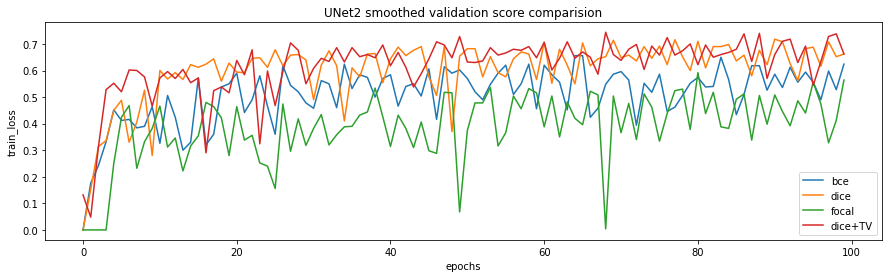

In [113]:
from statistics import mean 

ind=3
plt.plot(unet2_bce_history[ind], label="bce")
plt.plot(unet2_dice_history[ind], label="dice")
plt.plot(unet2_focal_history[ind], label="focal")
plt.plot(unet2_dice_TV_history[ind], label="dice+TV")

plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("train_loss")
plt.title("UNet2 smoothed validation score comparision")
plt.show()

Сделайте вывод какая из моделей лучше

# Отчет (6 баллов): 
Ниже предлагается написать отчет о проделанно работе и построить графики для лоссов, метрик на валидации и тесте. 
Если вы пропустили какую-то часть в задании выше, то вы все равно можете получить основную часть баллов в отчете, если правильно зададите проверяемые вами гипотезы.


Аккуратно сравните модели между собой и соберите наилучшую архитектуру. Проверьте каждую модель с различными лоссами. Мы не ограничиваем вас в формате отчета, но проверяющий должен отчетливо понять для чего построен каждый график, какие выводы вы из него сделали и какой общий вывод можно сделать на основании данных моделей. Если вы захотите добавить что-то еще, чтобы увеличить шансы получения максимального балла, то добавляйте отдельное сравнение.

Дополнительные комментарии: 

Пусть у вас есть N обученных моделей.
- Является ли отчетом N графиков с 1 линей? Да, но очень низкокачественным, потому что проверяющий не сможет сам сравнить их.

- Является ли отчетом 1 график с N линиями? Да, но скорее всего таким образом вы отразили лишь один эффект. Этого мало, чтобы сделать досточно суждений по поводу вашей работа.

- Я проверял метрики на трейне, и привел в результате таблицу с N числами, что не так? ключейвой момент тут, что вы измеряли на трейне ваши метрики, уверены ли вы, что заивисмости останутся такими же на отложенной выборке?

- Я сделал отчет содержащий график лоссов и метрик, и у меня нет ошибок в основной части, но за отчет не стоит максимум, почему? Естестественно максимум баллов за отчет можно получить не за 2 графика (даже при условии их полной правильности). Проверяющий хочет видеть больше сравнений моделей, чем метрики и лоссы (особенно, если они на трейне).

Советы: попробуйте правильно поставить вопрос на который вы себе отвечаете и продемонстрировать таблицу/график, помогающий проверяющему увидеть ответ на этот вопрос. Пример: Ваня хочет узнать, с каким из 4-х лоссов модель (например, U-Net) имеет наилучшее качество. Что нужно сделать Ване? Обучить 4 одинаковых модели с разными лосс функциями. И измерить итогововое качество. Продемонстрировать результаты своих измерений и итоговый вывод. (warning: конечно же, это не идеально ответит на наш вопрос, так как мы не учитываем в экспериментах возможные различные типы ошибок, но для первого приближения этого вполне достаточно).

Примерное время на подготовку отчета 1 час, он содержит сравнеение метрик, график лоссов, выбор лучших моделей из нескольких кластеров и выбор просто лучшей модели, небольшой вывод по всему дз, возможно сравнение результирующих сегментаций, времени или числа параметров модели, проявляйте креативность.

В данной работе мы изучали 3 модели: 
- SegNet, 
- Unet, 
- Unet с измененными слоями max-pooling и upsample 

обучив каждую из них на одинаковом датасете на одинаковом количестве эпох с четырьмя разными loss-функциями:
- BCE
- DICE
- FOCAL
- DICE с Total Variation

Сравним результаты обучения каждой можели на каждой loss-функции

In [114]:
def print_plot(history, ind, label):
    plt.figure(figsize=(15, 9))
    plt.plot(history[0][ind], label="bce")
    plt.plot(history[1][ind], label="dice")
    plt.plot(history[2][ind], label="focal")
    plt.plot(history[3][ind], label="dice+TV")

    plt.legend(loc='best')
    plt.xlabel("epochs")
    plt.title(f"{label}")
    plt.show()

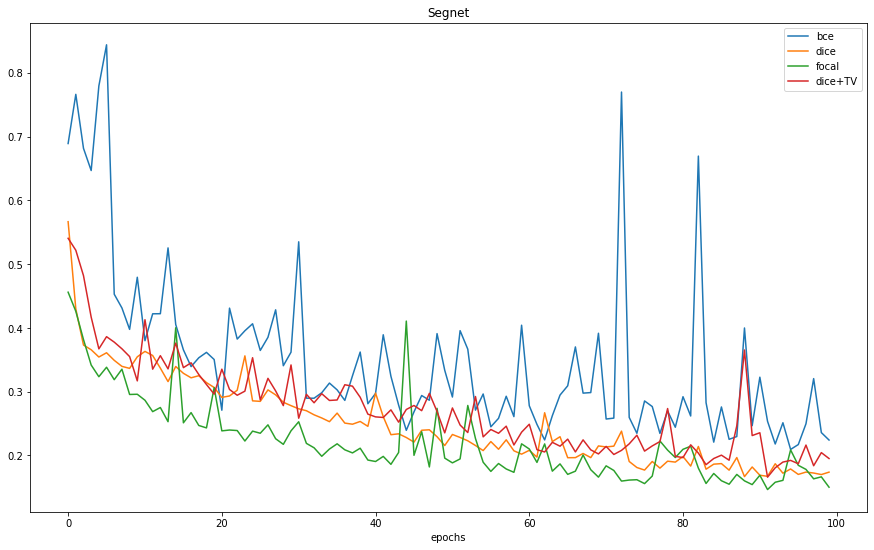

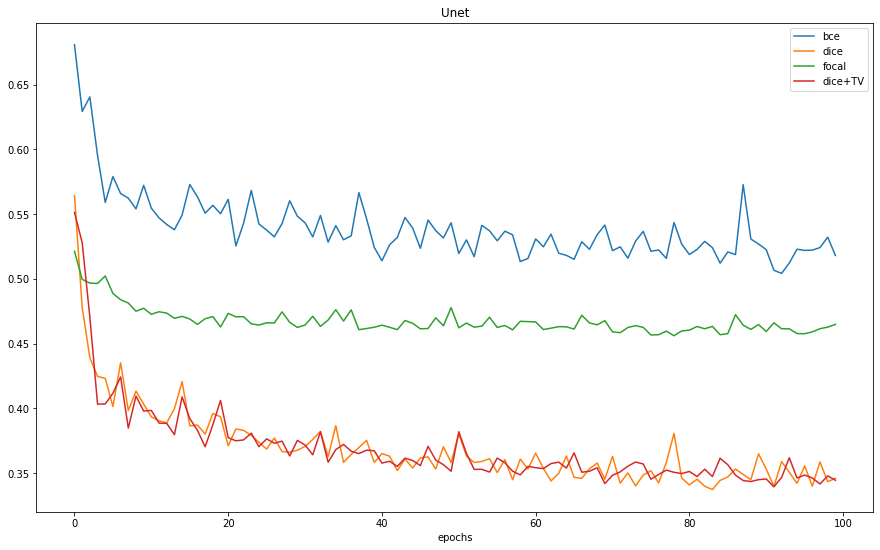

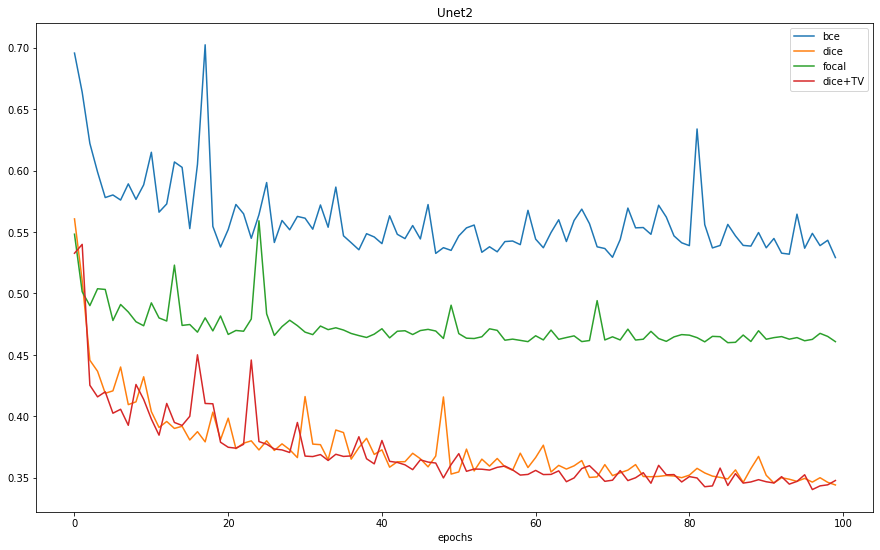

In [115]:
# распечатаем лосы
print_plot([segnet_bce_history, segnet_dice_history, segnet_focal_history, segnet_dice_TV_history], 1, 'Segnet')
print_plot([unet_bce_history, unet_dice_history, unet_focal_history, unet_dice_TV_history], 1, 'Unet')
print_plot([unet2_bce_history, unet2_dice_history, unet2_focal_history, unet2_dice_TV_history], 1, 'Unet2')

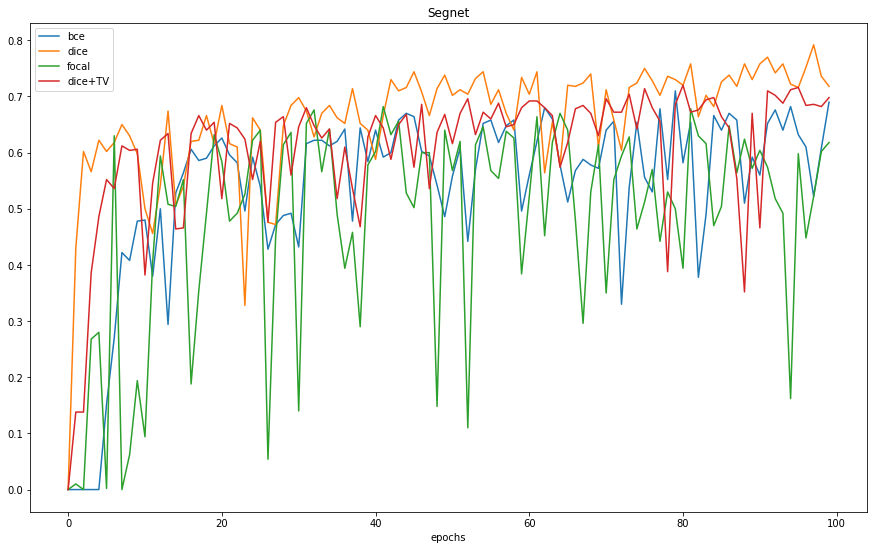

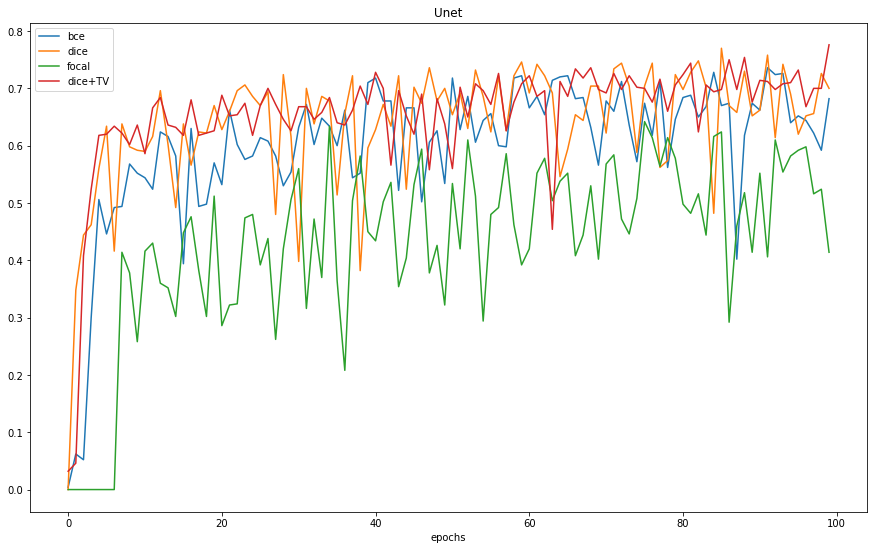

In [116]:
# теперь распечатаем скоры
print_plot([segnet_bce_history, segnet_dice_history, segnet_focal_history, segnet_dice_TV_history], 3, 'Segnet')
print_plot([unet_bce_history, unet_dice_history, unet_focal_history, unet_dice_TV_history], 3, 'Unet')
print_plot([unet2_bce_history, unet2_dice_history, unet2_focal_history, unet2_dice_TV_history], 3, 'Unet2')

Как можно заметить, **DICE** и **DICE с Total Variation** для всех трех моделей дают самый лучший результат.

Теперь сравним все три модели, обученые на этих loss-функциях:

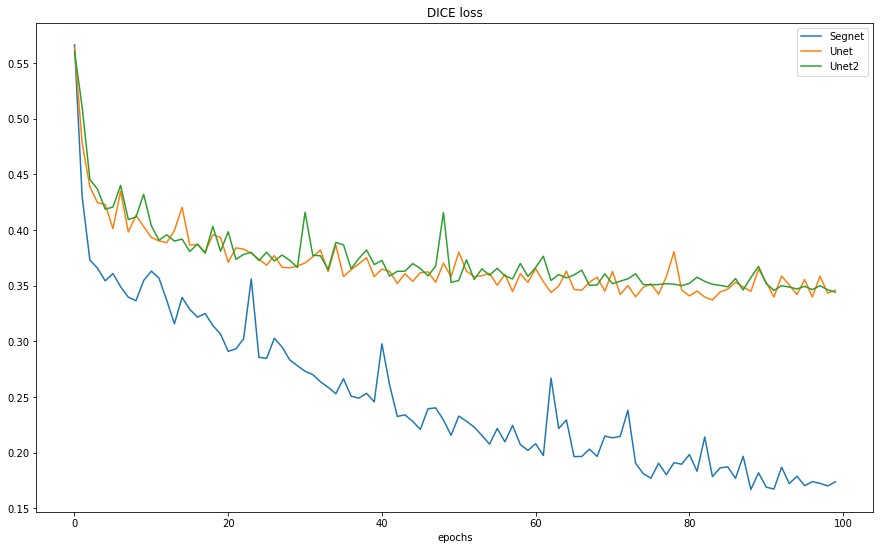

In [117]:
plt.figure(figsize=(15, 9))
plt.plot(segnet_dice_history[1], label="Segnet")
plt.plot(unet_dice_history[1], label="Unet")
plt.plot(unet2_dice_history[1], label="Unet2")

plt.legend(loc='best')
plt.xlabel("epochs")
plt.title(f"DICE loss")
plt.show()


plt.plot(segnet_dice_TV_history[1], label="Segnet")
plt.plot(unet_dice_TV_history[1], label="Unet")
plt.plot(unet2_dice_TV_history[1], label="Unet2")

plt.legend(loc='best')
plt.xlabel("epochs")
plt.title(f"DICE+TV loss")
plt.show()

Видно, что loss у Segnet уходит вниз сильнее, в то время как у моделей Unet и Unet2 он быстро выходит на плато

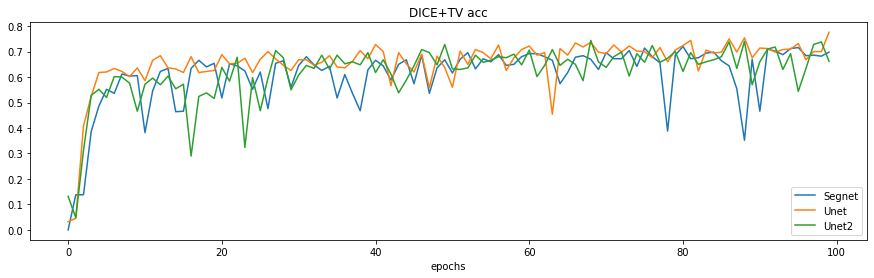

In [118]:
plt.figure(figsize=(15, 9))
plt.plot(segnet_dice_history[3], label="Segnet")
plt.plot(unet_dice_history[3], label="Unet")
plt.plot(unet2_dice_history[3], label="Unet2")

plt.legend(loc='best')
plt.xlabel("epochs")
plt.title(f"DICE acc")
plt.show()


plt.plot(segnet_dice_TV_history[3], label="Segnet")
plt.plot(unet_dice_TV_history[3], label="Unet")
plt.plot(unet2_dice_TV_history[3], label="Unet2")

plt.legend(loc='best')
plt.xlabel("epochs")
plt.title(f"DICE+TV acc")
plt.show()

Тем не менее, точность всех трех моделей на этих loss-функциях почти одинакова, особено это заметно у **DICE+TV**.
Однако можно заметить, что у второй loss-функции значения потерь и точности более стаблитьные.

Сравним результаты Segnet с DICE и Unet с DICE+TV, так как они показывают наилушие точности каждая на своей loss-функции соотвественно.

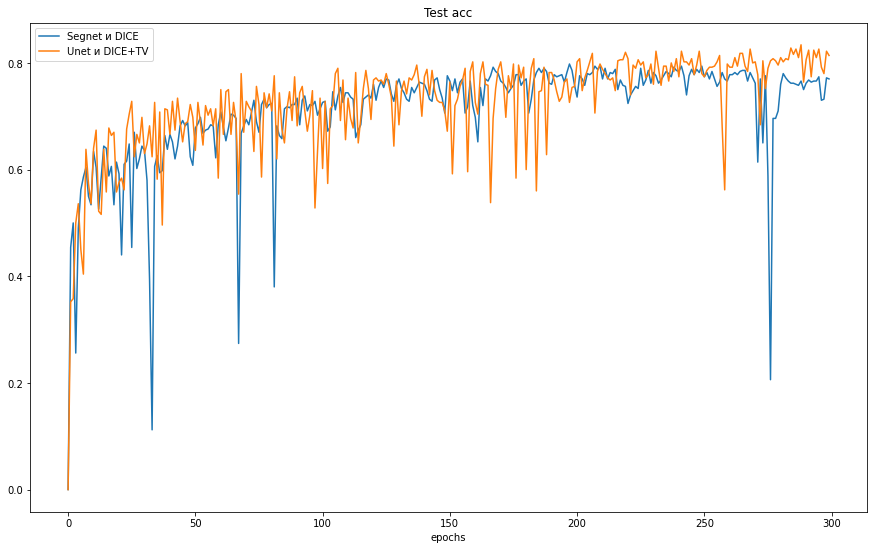

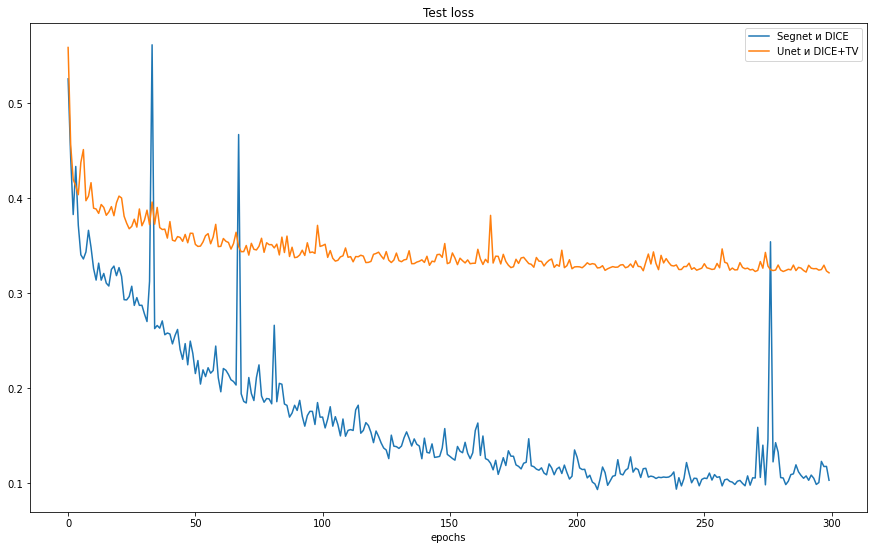

In [121]:
plt.figure(figsize=(15, 9))
plt.plot(segnet_dice_history[3], label="Segnet и DICE")
plt.plot(unet_dice_TV_history[3], label="Unet и DICE+TV")

plt.legend(loc='best')
plt.xlabel("epochs")
plt.title(f"Test acc")
plt.show()

plt.figure(figsize=(15, 9))
plt.plot(segnet_dice_history[1], label="Segnet и DICE")
plt.plot(unet_dice_TV_history[1], label="Unet и DICE+TV")

plt.legend(loc='best')
plt.xlabel("epochs")
plt.title(f"Test loss")
plt.show()

Результат сравнения показал, что точности моделей почти равны. Возможно, если увеличить количество эпох, результат изменится

100%|██████████| 300/300 [15:38<00:00,  3.13s/it]


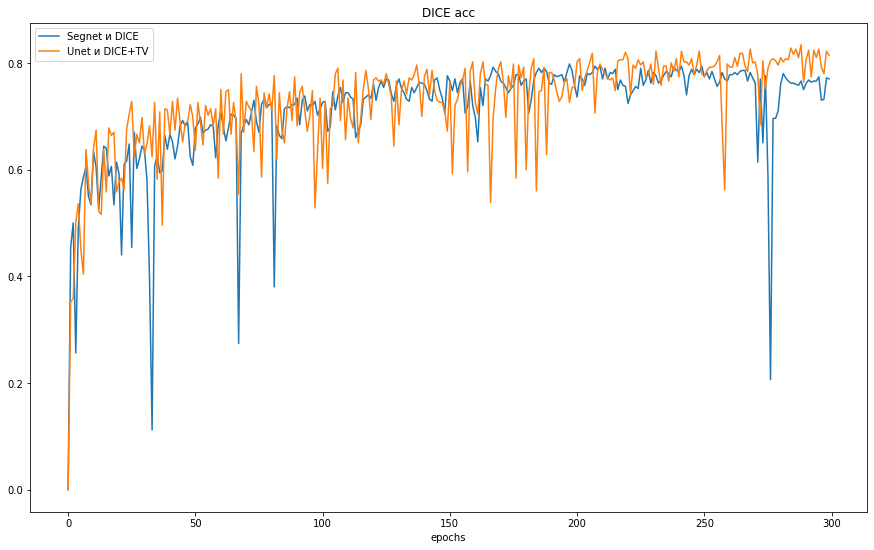

In [120]:
segnet = SegNet().to(device)
#segnet = nn.DataParallel(segnet).to(device)
optimizer = torch.optim.Adam(segnet.parameters())
segnet_dice_history = train(segnet, optimizer, dice_loss, iou_pytorch, 300, data_tr, data_vl)

unet = UNet().to(device)
#unet = nn.DataParallel(unet).to(device)
optimizer = torch.optim.Adam(unet.parameters())
unet_dice_TV_history = train(unet, optimizer, dice_TV_loss, iou_pytorch, 300, data_tr, data_vl)


plt.figure(figsize=(15, 9))
plt.plot(segnet_dice_history[3], label="Segnet и DICE")
plt.plot(unet_dice_TV_history[3], label="Unet и DICE+TV")

plt.legend(loc='best')
plt.xlabel("epochs")
plt.title(f"DICE acc")
plt.show()

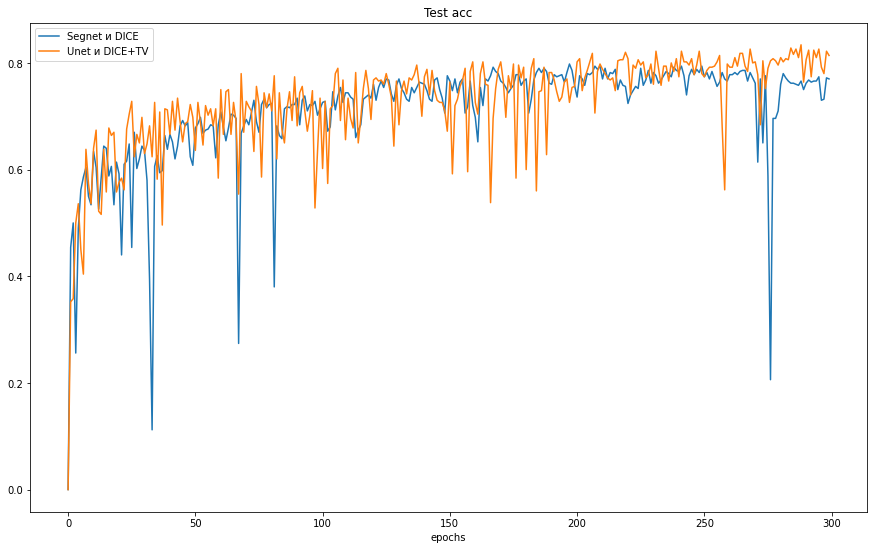

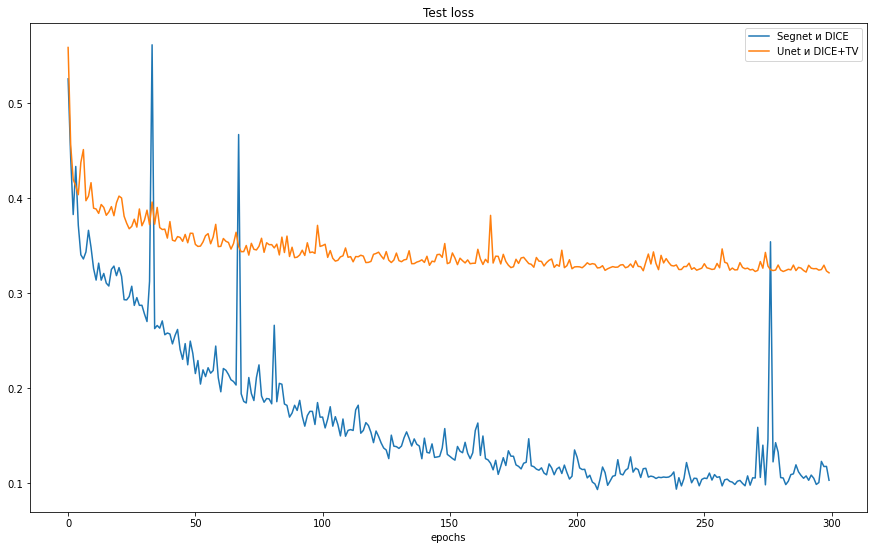

In [122]:
plt.figure(figsize=(15, 9))
plt.plot(segnet_dice_history[3], label="Segnet и DICE")
plt.plot(unet_dice_TV_history[3], label="Unet и DICE+TV")

plt.legend(loc='best')
plt.xlabel("epochs")
plt.title(f"Test acc")
plt.show()

plt.figure(figsize=(15, 9))
plt.plot(segnet_dice_history[1], label="Segnet и DICE")
plt.plot(unet_dice_TV_history[1], label="Unet и DICE+TV")

plt.legend(loc='best')
plt.xlabel("epochs")
plt.title(f"Test loss")
plt.show()

При обучении 300 эпохах Unet и DICE+TV показал лучшую точность. Не смотря на это, ошибка оказалась меньше у Segnet и DICE. Причем разница в ошибках сильно заметнее, чем в точности.

Посмотрим на результаты работы двух моделей

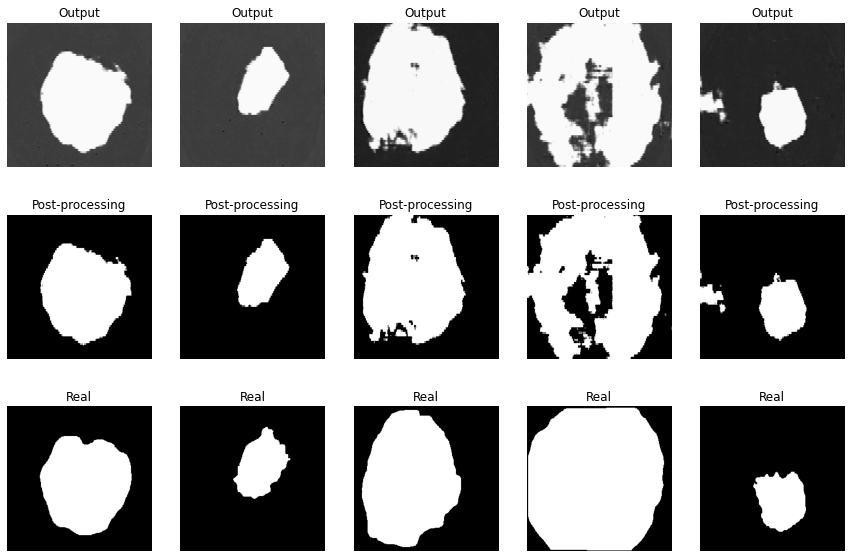

In [123]:
plot_items(segnet, data_ts, 5)

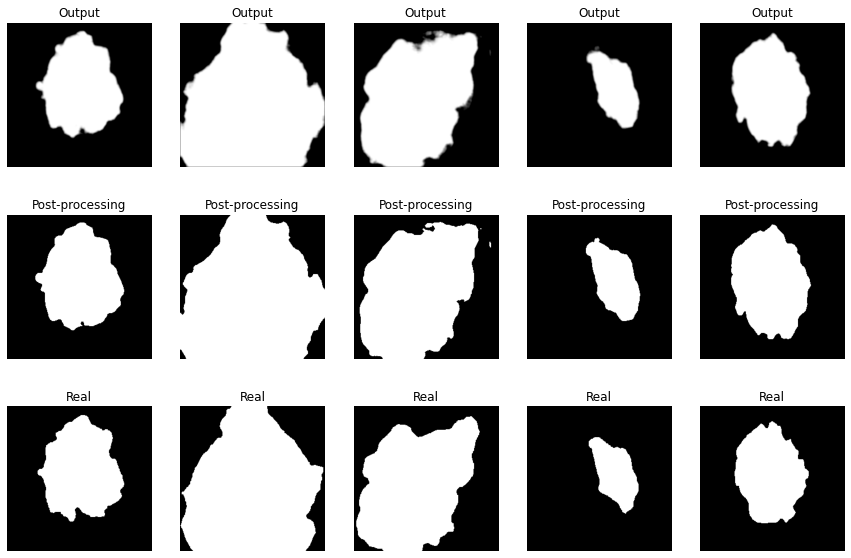

In [124]:
plot_items(unet, data_ts, 5)

Выходы модели с DICE+TV оказались более четкими за счет того, что TV накладывает штраф за нечеткие границы.

Сравним время, затрачиваемое моделями на обучение

### Segnet

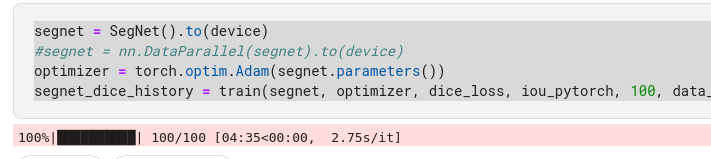

### Unet
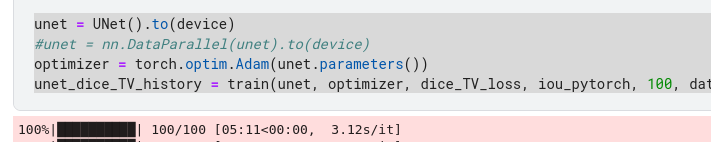

### Unet2
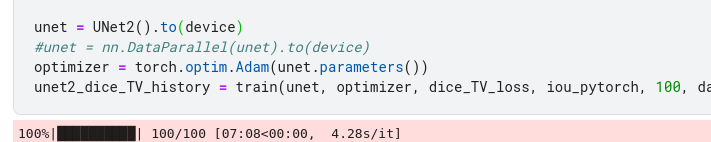

Время обучения на каждой из loss-функций примерно одинаково. Посчитаем среднее время обучения каждой из моделей в секундах.
- Segnet: 275с
- Unet: 311с
- Unet2: 428с

Таким образом, можно расчитать, что Unet учится на 13% дольше, чем SegNet, а Unet2 -- на 56%.

Можно сделать вывод, что добавление к модели Skip Connection,который реализован в Unet, действительно улучшает работу нейросети. Закономерно, из-за большего количества расчетов увеличивается и время, требуемое на тренировку.